In [1]:
import numpy as np
import healpy as hp
import os
import matplotlib as mpl
from   matplotlib import cm
import matplotlib.pyplot as plt
from scipy.integrate import cumtrapz
from astropy.constants import h
from astropy.constants import k_B

T_cmb = 2.7255

mpl.rcParams['text.usetex'] = True

In [2]:
# SED functions, all given in units of uK_RJ
def power_law(amp,ref,x,beta):
    return amp*(x/ref)**(beta)

def mbb(amp,ref,x,td,beta):
    # Inputs need to be in GHz.
    z = h.value / (k_B.value*td)
    return amp*(np.exp(z*ref*1e9)-1.0)/(np.exp(x*1e9*z)-1.0)*(x/ref)**(beta+1.0)

# Used to shift the spdust spectrum                                                                                                                                                                                
def sdust(nu, Asd, nu_p, nuref):
    nu_ref = nuref*1e9
    nu_p0 = 30.*1e9
    nu_p *= 1e9
    
    fnu, f = np.loadtxt("../../../ame_spectra/spdust2_cnm.dat", unpack=True)
    fnu *= 1e9
    # MAKE SURE THAT THESE ARE BOTH IN 1e9                                                                                                                                                                         
    scale = nu_p0/nu_p

    f = np.interp(scale*nu*1e9, fnu, f)
    f0 = np.interp(scale*nu_ref, scale*nu*1e9, f) # Value of s at nu_0
    # Move from intensity to uK_RJ
    s_sd = (nu_ref/nu*1e9)**2*f/f0
    return s_sd/np.max(s_sd)

# Convert from CMB units to RJ units
def cmb_to_rj(freq,data):
    y          = h.value*(freq*1e9)/ (k_B.value*T_cmb)
    conversion = (y**2.0*np.exp(y))/(np.exp(y)-1)**2.0
    return data*conversion

In [3]:
def mask_maps(mask,pol):
    for i in range(len(mask)):
        if (pol == 'Q'):
            if (mask[i] == hp.UNSEEN or mask[i] == 0.0):
                I_ame_over_I_353[i] = np.nan
                synch_Q_scaled[i]   = np.nan
        elif (pol == 'U'):
            if (mask[i] == hp.UNSEEN or mask[i] == 0.0):
                I_ame_over_I_353[i] = np.nan
                synch_U_scaled[i]   = np.nan
        else:
            print("Unusable pol type (use 'Q', or 'U').")
            
def sky_frac(mask):
    masked = 0
    for i in range(len(mask)):
        if (mask[i] == hp.UNSEEN or mask[i] == 0.0):
            masked += 1
            
    print('Sky fraction: ', 1.-masked/len(mask))

In [4]:
def plot_SED(loglin='log',amp_powerlaw=False):
    fig, ax = plt.subplots(figsize=(6,6))

    # Synch
    ax.fill_between(x,power_law(s_Q_mean,30.0,x,beta_s),power_law(s_U_mean,44.0,x,beta_s),color='gray',alpha=0.2,label='Synch')
#     ax.fill_between(x,power_law(s_P_mean,44.0,x,beta_s-0.01),power_law(s_P_mean,44.0,x,beta_s+0.01),color='gray',alpha=0.2,label='Synch')

 
    # MBB + AME Pol
    ax.plot(x,spdust_tot*(20./22.)+mbb(1.0,353.,x,19.6,1.62),color=colors[0],label=r'$p_{\mathrm{AME}}^{max} = 20\%$')
    ax.plot(x,spdust_tot*(10./22.)+mbb(1.0,353.,x,19.6,1.62),color=colors[2],label=r'$p_{\mathrm{AME}}^{max} = 10\%$')
    ax.plot(x,spdust_tot*(5./22.)+mbb(1.0,353.,x,19.6,1.62),color=colors[4],label=r'$p_{\mathrm{AME}}^{max} = 5\%$')
    ax.plot(x,spdust_tot*(1./22.)+mbb(1.0,353.,x,19.6,1.62),color=colors[6],label=r'$p_{\mathrm{AME}}^{max} = 1\%$')
    
#     if amp_powerlaw:
#         ax.plot(x,power_law(dust_Q_means[6],freq[6],x,beta_s),'k--')
    
    ax.plot(x,mbb(1.0,353.,x,19.6,1.62),color=colors[8],label=r'$p_{\mathrm{AME}}^{max} = 0\%$') # Planck 2018 Dust Pol MBB
    ax.fill_between(x,mbb(1.0,353.,x,19.6,beta_d_mean-beta_d_std),mbb(1.0,353.,x,19.5,beta_d_mean+beta_d_std),color=colors[8],alpha=0.2) # Planck 2018 Dust Pol MBB
    
    # Fit dust amplitudes
    k = 0
    ax.errorbar(freq,dust_plus_thermal_amp,dust_plus_thermal_err,fmt='.',color='k',zorder=10,label='This work')
#     ax.errorbar(freq,dust_Q_means,dust_Q_std,fmt='.',color='k',zorder=10,label='This work')
    ax.errorbar(planck_XI_freq,planck_XI_mean,yerr=planck_XI_err,color='red',fmt='.',zorder=10,label='Planck XI EE')
    if all(i >= 0.0 for i in dust_plus_thermal_amp):
#     if all(i >= 0.0 for i in dust_U_amps[0][:]):
        if (loglin == 'lin'):
            ax.set_ylim([-0.05,0.6])
            ax.set_xlim([5,100])  
        if (loglin == 'log'):
            ax.set_yscale('log')
            ax.set_xscale('log')
            ax.set_ylim([1e-2,2e0])
            ax.set_xlim([10,200.])
    else:
#         ax.set_ylim([-0.025,0.5])
        ax.set_ylim([-0.25,0.6])
        ax.set_xlim([5,100])    
        if amp_powerlaw:
#             ax.plot(x,-1.0*(power_law(dust_plus_thermal_amp[3],freq[3],x,beta_s))+2*dust_plus_thermal_amp[3],'k--')
            ax.plot(x,-1.0*(power_law(dust_plus_thermal_amp[4],freq[4],x,beta_s))+2*dust_plus_thermal_amp[4],'k--')
    ax.set_xticks([10, 40, 100])
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    ax.set_ylabel(r'$A/A_{353}\, [\mathrm{Brightness\, Temperature\, Units}]$',size=20)
    ax.set_xlabel(r'$\mathrm{Frequency\, [GHz]}$',size=20)
    ax.legend(loc=1)
    plt.rc('ytick',labelsize=20)
    plt.rc('xtick',labelsize=20)
    if amp_powerlaw:
        plt.savefig('../'+dir+'/sed_fgs_mean_amp_powerlaw'+version+'.pdf',dpi=300,bbox_inches='tight')
    else:
        plt.savefig('../'+dir+'/sed_fgs_mean_'+version+'.pdf',dpi=300,bbox_inches='tight')
#     plt.show()    

def fit_ame_2_amps(sdust,mbb,x,amps,freqs,err):
    pols  = np.linspace(0,1,1000)
    chisq = np.empty(1000)
    
    sed_size = len(mbb)
#     print(sed_size)
    
    sig = np.empty((len(mbb),len(chisq)))
    
    
    for i in range(1000):
        sig[i] = mbb+pols[i]*sdust
        for j in range(len(amps)):
            chisq[i] += ((amps[j]-np.interp(freqs[j],x,sig[i]))**2)/(err[j]**2)
     
    indx = np.where(chisq == np.min(chisq))
    pmax = 22*pols
    post = np.exp(-0.5*chisq)
    norm = np.trapz(post,pols)
    
    cumul = np.cumsum(post)
    
    dummy = np.empty(1000)

    xfill = np.where(cumul/cumul[-1] < 0.95)[-1]
    
    return post/norm

def plot_ame():
    
    fig, ax = plt.subplots(figsize=(6,6))

    # MBB + AME Pol
    ax.plot(x,spdust_tot*(20./22.),color=colors[0],label=r'$p_{\mathrm{AME}}^{max} = 20\%$')
    ax.plot(x,spdust_tot*(10./22.),color=colors[2],label=r'$p_{\mathrm{AME}}^{max} = 10\%$')
    ax.plot(x,spdust_tot*(5./22.),color=colors[4],label=r'$p_{\mathrm{AME}}^{max} = 5\%$')
    ax.plot(x,spdust_tot*(1./22.),color=colors[6],label=r'$p_{\mathrm{AME}}^{max} = 1\%$')
    ax.plot(x,spdust_tot*(0./22.),color=colors[8],label=r'$p_{\mathrm{AME}}^{max} = 0\%$')
    
#     ax.plot(x,power_law(dust_Q_means[3],freq[3],x,-2.832),label='Synch power-law')
    
    ax.errorbar(freq,dust_Q_means,dust_Q_std,fmt='.',color='k',zorder=10,label='This work')
    
    ax.set_ylim([-0.025,0.5])
    ax.set_xlim([5,80])
    ax.set_xticks([10, 40, 70])
    ax.set_xticks([10, 40, 70])
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    ax.set_ylabel(r'$a_{\rm AME}\, [\mathrm{Brightness\, Temperature\, Units}]$',size=20)
    ax.set_xlabel(r'$\mathrm{Frequency\, [GHz]}$',size=20)
    ax.legend(loc=1)
#     ax.axhline(0,linestyle='--',color='k')
    plt.rc('ytick',labelsize=20)
    plt.rc('xtick',labelsize=20)
    plt.savefig('../'+dir+'/a_ame_'+version+'.pdf',dpi=300,bbox_inches='tight')
    plt.show()

In [5]:
def read_params(filename):
    labels = []
    freq   = []
    with open(filename,'r') as infile:
        for line in infile:
            if line.startswith('NUMBAND'):
                numbands = int(line.split('=')[1])
            if line.startswith('NUMGIBBS'):
                numgibbs = int(line.split('=')[1][:5])
            if line.startswith('COMP_PRIOR_GAUSS_BETA_MEAN01'):
                beta_s = float(str.strip(line.split('=')[1]))
            if line.startswith('MBB_TD_MEAN'):
                t_d_mean = float(str.strip(line.split('=')[1]))
            if line.startswith('MBB_TD_STD'):
                t_d_std = float(str.strip(line.split('=')[1]))
            if line.startswith('MBB_BETA_MEAN'):
                beta_d_mean = float(str.strip(line.split('=')[1]))
            if line.startswith('MBB_BETA_STD'):
                beta_d_std = float(str.strip(line.split('=')[1]))
                
    blabs = []
    bfreq = []
    for band in range(numbands):
        blabs.append('BAND_LABEL'+str(band+1).zfill(3))
        bfreq.append('BAND_FREQ'+str(band+1).zfill(3))        
    for band in range(numbands):
         with open(filename,'r') as infile:
            for line in infile:
                if line.startswith(blabs[band]):
                    name = str.strip(line.split('=')[1])
                    labels.append(name)
                if line.startswith(bfreq[band]):
                    fre  = str.strip(line.split('=')[1])
                    freq.append(float(fre))                    
    
    return labels, freq, numgibbs, beta_s, t_d_mean, t_d_std, beta_d_mean, beta_d_std

def read_mask(filename):
    with open(filename,'r') as infile:
        for line in infile:
            if line.startswith('MASKFILE'):
                maskfile = str.strip(line.split('=')[1])
    maskfile = '../'+maskfile[1:-1]
#     print(maskfile)
    mask = hp.read_map(maskfile,verbose=False)
    
    return mask

In [6]:
# ame_col = ['yellow','gold','orange','darkorange','orangered']
ame_col = ['goldenrod','orange','darkorange','chocolate','saddlebrown']
amp_col = ['royalblue','cadetblue','steelblue','darkturquoise','cyan']
colors = [cm.plasma(i) for i in np.linspace(0, 1, 12)]

# Planck 2015 2 component AME details
ame_comp1      = [92.,22.8,20.]   #<A_SD>,ref and peak freqs in GHz
ame_comp2      = [18.,40.1,33.35] #<A_SD>,ref and peak freqs in GHz
# Planck 2018 XI dust fit LFI
planck_XI_freq = [44.1,70.3]
planck_XI_mean = [6.0e-3,9.46e-3]
planck_XI_err  = [1.1e-3,0.75e-3]

for i in range(2):
    planck_XI_mean[i] = 1/(cmb_to_rj(353.,1.0))*cmb_to_rj(planck_XI_freq[i],planck_XI_mean[i])
    planck_XI_err[i]  = 1/(cmb_to_rj(353.,1.0))*cmb_to_rj(planck_XI_freq[i],planck_XI_err[i])

In [19]:
dir     = str(input('Which directory are we wanting to plot from? '))
version = dir[dir.index('v'):dir.index('v')+3]
# print(version)

names, freq, num_samp, beta_s, t_d_mean, t_d_std, beta_d_mean, beta_d_std = read_params('../'+dir+'/param_'+dir+'.txt')
labels = [name.replace("'","") for name in names]
labels = [w.replace("_","\_") for w in labels]
num_bands = len(freq)
mask = read_mask('../'+dir+'/param_'+dir+'.txt')
print("Band labels:     ",labels)
print("Fit frequencies: ",freq)
print("Beta Synch Mean: ",beta_s)
print("Dust Temp prior: ",t_d_mean, t_d_std)
print("Dust Beta prior: ",beta_d_mean, beta_d_std)

Which directory are we wanting to plot from?  metrop_v09


Band labels:      ['bp\\_030', 'bp\\_044', 'bp\\_070', 'wmap\\_Ka', 'wmap\\_Q', 'wmap\\_V', 'wmap\\_K']
Fit frequencies:  [28.4, 44.1, 70.3, 33.0, 40.6, 60.8, 22.8]
Beta Synch Mean:  -3.0
Dust Temp prior:  19.6 0.0
Dust Beta prior:  1.62 0.04


In [20]:
dust_353     = hp.read_map('../data/npipe6v20_353_map_n0064_60arcmin_uK.fits',field=(0,1,2),verbose=False)
dust_353_rms = hp.read_map('../data/npipe6v20_353_n0064_rms_tqu_uK.fits',field=(0,1,2),verbose=False)
ame_map      = hp.read_map('/home/daniel/data/planck_products/COM_CompMap_AME-commander_0064_R2.00.fits',field=0,verbose=False)
npix         = len(ame_map)

# synch_Q_044  = hp.read_map('../'+dir+'/synch_Q_mean.fits',verbose=False)
# synch_U_044  = hp.read_map('../'+dir+'/synch_U_mean.fits',verbose=False)
synch_Q_030  = hp.read_map('../'+dir+'/synch_Q_030_mean.fits',verbose=False)
synch_U_030  = hp.read_map('../'+dir+'/synch_U_030_mean.fits',verbose=False)
dust_Q_amps  = np.loadtxt('../'+dir+'/dust_353_Q_amplitudes.dat')
dust_U_amps  = np.loadtxt('../'+dir+'/dust_353_U_amplitudes.dat')
dust_353     = cmb_to_rj(353,dust_353)
dust_353_rms = cmb_to_rj(353,dust_353_rms)

dust_Q_means = np.empty(np.shape(dust_Q_amps)[1])
dust_U_means = np.empty(np.shape(dust_U_amps)[1])
dust_Q_std   = np.empty(np.shape(dust_Q_amps)[1])
dust_U_std   = np.empty(np.shape(dust_U_amps)[1])

for i in range(len(dust_Q_means)):
    dust_Q_means[i] = np.mean(dust_Q_amps.T[:][i])
    dust_U_means[i] = np.mean(dust_U_amps.T[:][i])
    dust_Q_std[i]   = np.std(dust_Q_amps.T[:][i])
    dust_U_std[i]   = np.std(dust_U_amps.T[:][i])
  
print("Dust amplitude means: ",dust_Q_means)
print("Dust amplitude stds:  ",dust_Q_std)
print("Fit frequencies:      ",freq)

# This approach will be to divide each map by the actual npip26v20 353 (Q or U) map for normalization
# In essence, this means that in our 'units', the npipe6v20 is equal to 1.0 everywhere.

# The idea here is that if the AME is as polarized as dust, then
# Q_{AME}/Q_{dust,353} = I_{AME}/I_{dust,353} <- cmb corrected of course
mono_dip         = hp.remove_dipole(dust_353[0][:],gal_cut=75,verbose=False,fitval=True)
dust_353[0][:]   = hp.remove_dipole(dust_353[0][:],gal_cut=75,verbose=False) + mono_dip[1]
# synch_Q_scaled   = synch_Q_044/dust_353[1]
# synch_U_scaled   = synch_U_044/dust_353[2]
synch_Q_scaled   = synch_Q_030/dust_353[1]
synch_U_scaled   = synch_U_030/dust_353[2]
I_ame_over_I_353 = ame_map/dust_353[0][:]

mask_maps(mask,'Q')
mask_maps(mask,'U')
sky_frac(mask)

# Some plotting array of frequencies
x           = np.linspace(5,1000,1000)
spdust_tot  = ame_comp1[0]*sdust(x,ame_comp1[0],ame_comp1[2],ame_comp1[1]) + ame_comp2[0]*sdust(x,ame_comp2[0],ame_comp2[2],ame_comp2[1])
spdust_tot  = spdust_tot/np.max(spdust_tot)

ame_over_353_median = np.nanmedian(I_ame_over_I_353)
ame_over_353_mean   = np.nanmean(I_ame_over_I_353)
# print(ame_over_353_median)
print("I_AME/I_353:  ", ame_over_353_mean)
spdust_tot *= ame_over_353_mean

s_Q_mean = np.nanmean(synch_Q_scaled)
s_Q_std  = np.nanstd(synch_Q_scaled)
s_Q_low  = s_Q_mean - s_Q_std
s_Q_high = s_Q_mean + s_Q_std
# print("Synch Q:      ",s_Q_low,s_Q_mean,s_Q_high)

s_U_mean = np.nanmean(synch_U_scaled)
s_U_std  = np.nanstd(synch_U_scaled)
s_U_low  = s_U_mean - s_U_std
s_U_high = s_U_mean + s_U_std
# print("Synch U:      ",s_U_low,s_U_mean,s_U_high)

# synch_P_scaled = np.empty(npix)

# for i in range(npix):
#     synch_P_scaled[i] = np.sqrt(synch_Q_scaled[i]**2 + synch_U_scaled[i]**2)

# hp.mollview(synch_P_scaled,min=0.0,max=15)
# hp.mollview(synch_U_scaled,min=-2.5,max=2.5)
# plt.show()

# print(np.mean(synch_P_scaled))

# s_Q_mean = 0.5

Dust amplitude means:  [0.64291189 0.16279503 0.         0.42209909 0.21142525 0.
 1.27947732]
Dust amplitude stds:   [0.01020754 0.00201943 0.         0.00621374 0.003271   0.
 0.01814118]
Fit frequencies:       [28.4, 44.1, 70.3, 33.0, 40.6, 60.8, 22.8]
Sky fraction:  0.9105428059895834
I_AME/I_353:   0.5128199076652228


In [21]:
# ax.fill_between(x,mbb(1.0,353.,x,19.6,beta_d_mean-beta_d_std),mbb(1.0,353.,x,19.5,beta_d_mean+beta_d_std),color=colors[8],alpha=0.2) # Planck 2018 Dust Pol MBB
thermal_amp = []
thermal_err = []
for i in range(len(freq)):
    thermal_amp.append(mbb(1.0,353.,freq[i],19.6,beta_d_mean))
    thermal_err.append(abs(mbb(1.0,353.,freq[i],19.6,beta_d_mean+beta_d_std) - mbb(1.0,353.,freq[i],19.6,beta_d_mean)))

print(thermal_amp)
print(dust_Q_means)
print(thermal_err)
print(freq)

[0.025877414995610786, 0.05176836453169209, 0.1066315696110724, 0.03281415897514916, 0.04547568298209376, 0.08529591651145876, 0.01825611181279901]
[0.64291189 0.16279503 0.         0.42209909 0.21142525 0.
 1.27947732]
[0.002481359866555736, 0.00413283467351213, 0.006665405708088559, 0.0029678351147905124, 0.003768651155401412, 0.00579476940629918, 0.0018949291743257449]
[28.4, 44.1, 70.3, 33.0, 40.6, 60.8, 22.8]


[0.6687893036956108, 0.2145633906316921, 0.45491325227514917, 0.25690093328209374, 1.297733433812799]
[0.010504808035557475, 0.004599828312132954, 0.006886116654962482, 0.0049902098315004065, 0.01823987543157646]
[28.4, 44.1, 33.0, 40.6, 22.8]


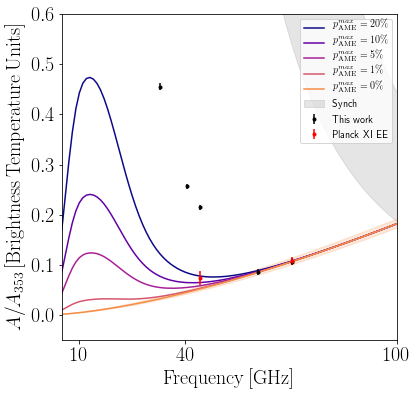

In [22]:
dust_plus_thermal_amp = []
dust_plus_thermal_err = []
for i in range(len(dust_Q_means)):
    dust_plus_thermal_amp.append(dust_Q_means[i] + thermal_amp[i])
    dust_plus_thermal_err.append(np.sqrt(dust_Q_std[i]**2 + thermal_err[i]**2))
t_err   = []
t_amps  = []
t_freqs = []
for i in range(len(dust_Q_means)):
    if dust_Q_means[i] != 0.0:
#         t_amps.append(dust_Q_means[i])
#         t_err.append(dust_Q_std[i])
        t_amps.append(dust_Q_means[i]+thermal_amp[i])
        t_err.append(np.sqrt(dust_Q_std[i]**2+thermal_err[i]**2))
        t_freqs.append(freq[i])
        
print(t_amps)        
print(t_err)
print(t_freqs)

# if (t_d_std != 0.0):
T_d = t_d_mean #np.linspace(19.5,19.7,100)
# else:
#     T_d = np.linspace(t_d_mean-t_d_std,t_d_mean+t_d_std,100)
if (beta_d_std != 0.0):
    beta_d = np.linspace(beta_d_mean-beta_d_std,beta_d_mean+beta_d_std,1000)
else:
    beta_d = beta_d_mean
pmax  = np.linspace(0,22,1000)
vals  = np.empty(1000)
vals  = 0.0

# for i in range(1000):
#     vals += fit_ame_2_amps(spdust_tot,mbb(1.0,353.,x,T_d,beta_d[i]),x,t_amps,t_freqs,t_err)

# norm  = np.trapz(vals,pmax)    
# cumul = np.cumsum(vals)    
# dummy = np.empty(1000)
# xfill = np.where(cumul/cumul[-1] < 0.95)[-1]
# dummy[:] = 0.0    

# print("Posterior maximum: ",float(pmax[np.where(vals == np.max(vals))]))
# print("Max(pmax): ",np.max(pmax[:xfill[-1]]))

# fig, ax = plt.subplots(figsize=(6,6))
# ax.plot(pmax,vals/norm)
# ax.set_xlabel(r'$p_{\rm max}\, [{\rm \%}]$',size=20)
# ax.set_ylabel(r'$p(p_{\rm max}\,|A_{\rm d},\,A_{\rm s},\,{\rm d})$',size=20)
# ax.set_xlim([0,20])
# ax.set_ylim([0,1.1*np.max(vals/norm)])
# ax.fill_between(pmax[:xfill[-1]],dummy[:xfill[-1]],vals[:xfill[-1]]/norm,color='blue',alpha=0.4,label=r'${\rm 95\,\%\, Confidence\, Interval}$')
# plt.savefig('../'+dir+'/P_amp_bestfit_posterior_'+version+'.pdf',dpi=300,bbox_inches='tight')
# plt.show()

plot_SED('lin')

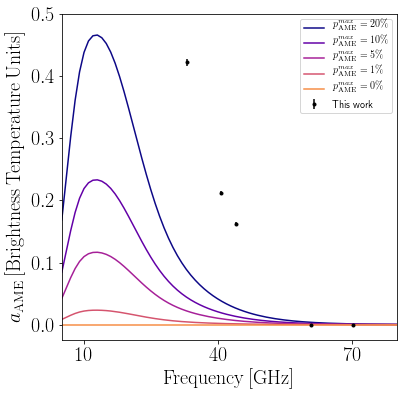

In [23]:
plot_ame()